<a href="https://colab.research.google.com/github/shihanxie/Econ475/blob/main/LiqourSale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Putting it together
We use liquor sale as and example to model and forecast a variable with a quardratic trend, seasonal dummies, and a cyclical component

In [ ]:
# Run this cell as the first step to make sure we use the most updated version of statsmodels in python
# If it fails to import the latest version, try click Runtime -> Restart runtime and start from here again
!pip install statsmodels==0.12.0
import statsmodels

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

### Import and plot data
- The sample is monthly and covers the period from 1968M1 to 1995M12
- We first use the sample up to 1994M12 (do not include observations from 1995)

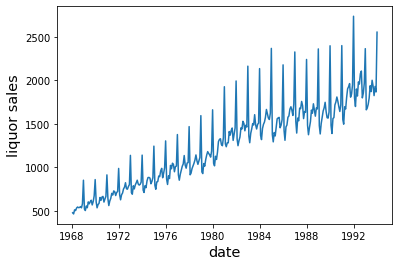

In [ ]:
liquor = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/DataLiquor.csv')
liquor['date'] = pd.date_range(start='1968-01-01', periods= liquor.shape[0], freq='M')

# We exclude the last 24 months of data from our analysis
plt.plot(liquor['date'][:-24], liquor['liquorsales'][:-24])
ax = plt.gca()
ax.set_ylabel('liquor sales', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

Generate and plot ```log(liquor sale)```

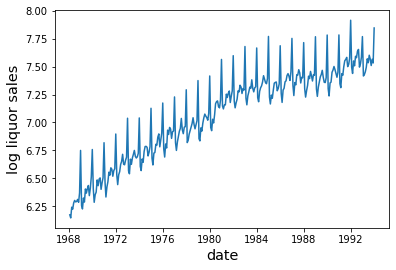

In [ ]:
liquor['logliquor'] = np.log(liquor['liquorsales'])

plt.plot(liquor['date'][:-24], liquor['logliquor'][:-24])
ax = plt.gca()
ax.set_ylabel('log liquor sales', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

## Quadratic trend model

In [ ]:
# Generate constant and time variables
liquor['constant'] = 1
liquor['time'] = liquor.index + 1
liquor['time2'] = liquor['time']**2

# Quadratic trend model
Y = ['logliquor']
X_quadratic = ['constant','time','time2']

result_quadratic = sm.OLS(liquor[Y][:-24], liquor[X_quadratic][:-24], missing='drop').fit()
print(result_quadratic.summary())

                            OLS Regression Results                            
Dep. Variable:              logliquor   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     1457.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          4.55e-158
Time:                        23:27:20   Log-Likelihood:                 207.22
No. Observations:                 312   AIC:                            -408.4
Df Residuals:                     309   BIC:                            -397.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       6.2437      0.021    291.871      0.0

In [ ]:
np.sqrt(result_quadratic.mse_resid)

###Residual Plot

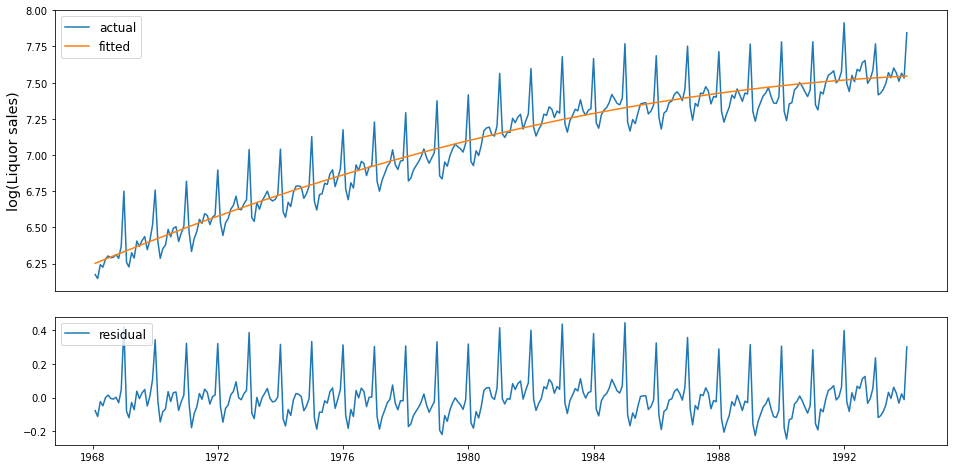

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(df['date'][:-24], df[Y][:-24], label = 'actual')
ax1.plot(df['date'][:-24], result_quadratic.fittedvalues, label = 'fitted')

ax2.plot(df['date'][:-24], result_quadratic.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

If you only want to plot the residuals:

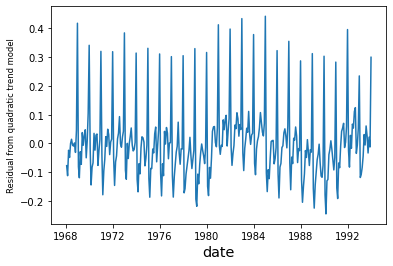

In [ ]:
plt.plot(liquor['date'][:-24], result_quadratic.resid)
ax = plt.gca()
ax.set_ylabel('Residual from quadratic trend model', fontsize = 'small')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

### Plot the correlogram of the residuals

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


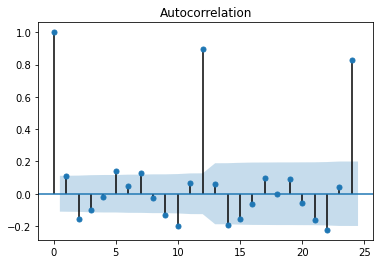

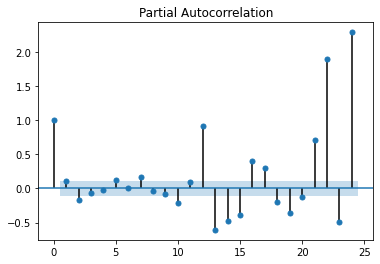

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_quadratic.resid, lags=24)
plot_pacf(result_quadratic.resid, lags=24)
plt.show()

## Trend and Seasonal Model

In [ ]:
# Generate dummy variables for every month
liquor['month'] = pd.DatetimeIndex(liquor['date']).month
dummy = pd.get_dummies(liquor['month'], prefix='m')

# Merge the dummies variables with liquor sales data and obtain a new DataFrame named "df"
df = pd.concat([liquor,dummy], axis=1)

In [ ]:
Y = ['logliquor']
X_season = ['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']

result_season = sm.OLS(df[Y][:-24], df[X_season][:-24], missing='drop').fit()
print(result_season.summary())

                            OLS Regression Results                            
Dep. Variable:              logliquor   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1945.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          2.43e-279
Time:                        23:28:03   Log-Likelihood:                 536.03
No. Observations:                 312   AIC:                            -1044.
Df Residuals:                     298   BIC:                            -991.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0074      0.000     66.266      0.0

In [ ]:
np.sqrt(result_season.mse_resid)

0.04442204472492902

Breusch-Godfrey test for serial correlations in the residuals

In [ ]:
from statsmodels.stats import diagnostic
bgtest = diagnostic.acorr_breusch_godfrey(result_season, nlags = 12)
print('Breusch Godfrey test LM statistic: ', bgtest[0])
print('Breusch Godfrey test LM p-value: ', bgtest[1])

Breusch Godfrey test LM statistic:  200.52833443313983
Breusch Godfrey test LM p-value:  2.5372019288058615e-36


### Residual plot

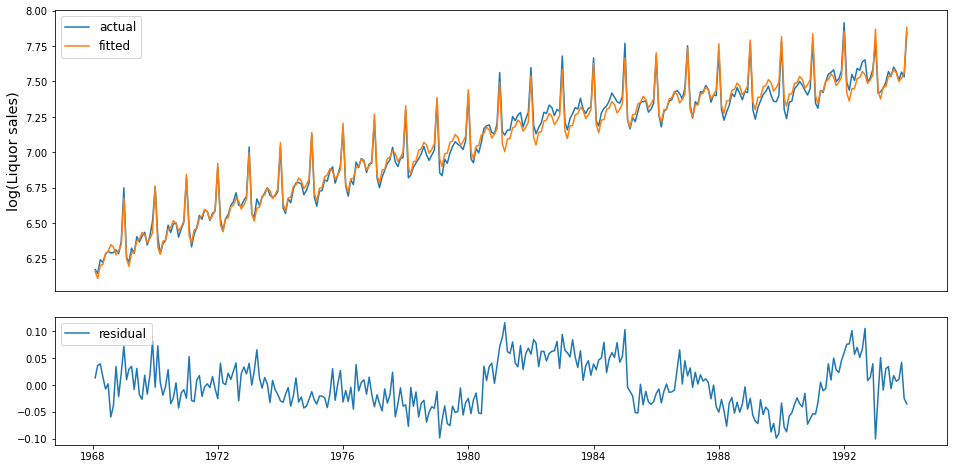

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(df['date'][:-24], df[Y][:-24], label = 'actual')
ax1.plot(df['date'][:-24], result_season.fittedvalues, label = 'fitted')

ax2.plot(df['date'][:-24], result_season.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

Exercise: plot the residuals from the seasonal regression and label it properly



### Plot correlogram of the residuals

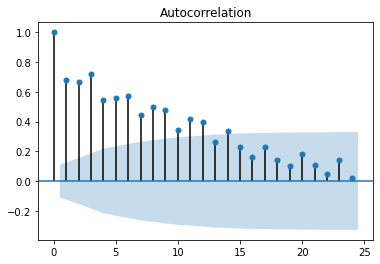

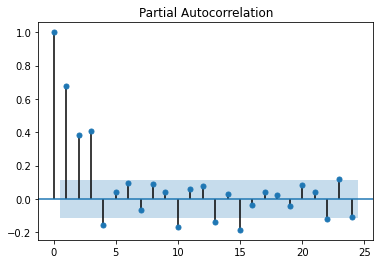

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_season.resid, lags=24)
plot_pacf(result_season.resid, lags=24)
plt.show()

## Model with quadratic trend, a full set of seasonal dummies and AR(3)

In [ ]:
# Include time, time**2, and seasonal dummies as exogenous variables
# trend='n': exclude constant term to avoid dummy trap
X1 = ['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']
result_arma = ARIMA(df['logliquor'][:-24], order=(3,0,0), trend='n', exog=df[X1][:-24]).fit()
print(result_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              logliquor   No. Observations:                  312
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 683.015
Date:                Wed, 10 Mar 2021   AIC                          -1330.030
Time:                        03:01:26   BIC                          -1262.656
Sample:                             0   HQIC                         -1303.103
                                - 312                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0074      0.001     13.459      0.000       0.006       0.009
time2      -1.058e-05   1.59e-06     -6.659      0.000   -1.37e-05   -7.46e-06
m_1            6.1531      0.040    153.444      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


###Durbin-Watson test and Breusch-Godfrey test for serial correlations in the residuals

In [ ]:
bgtest = diagnostic.acorr_breusch_godfrey(result_arma, nlags = 12)
print('Breusch Godfrey test LM statistic: ', bgtest[0])
print('Breusch Godfrey test LM p-value: ', bgtest[1])

Breusch Godfrey test LM statistic:  28.94619656931001
Breusch Godfrey test LM p-value:  0.004013104051841058


In [ ]:
from statsmodels.stats import stattools as st
st.durbin_watson(result_arma.resid)

1.8578146602572425

### Residual plot

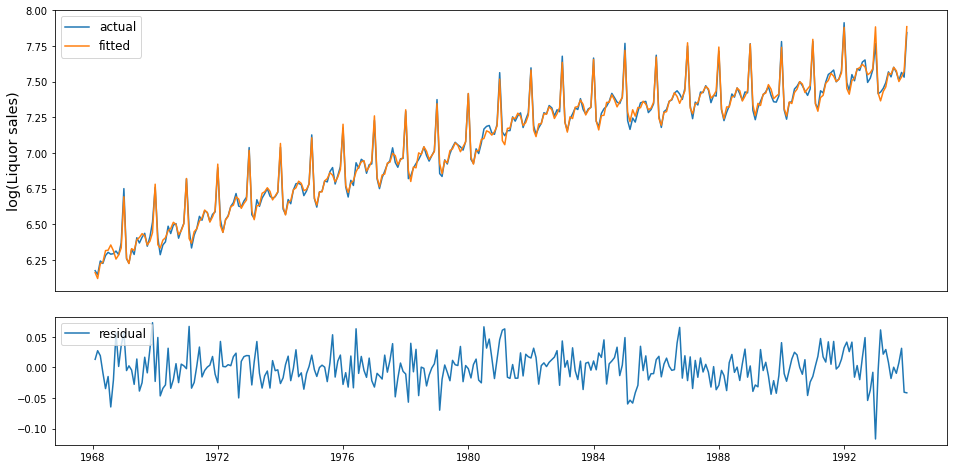

In [ ]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(df['date'][:-24], df[Y][:-24], label = 'actual')
ax1.plot(df['date'][:-24], result_arma.fittedvalues, label = 'fitted')

ax2.plot(df['date'][:-24], result_arma.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

###Plot correlogram of the residuals

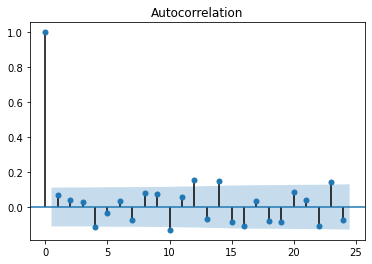

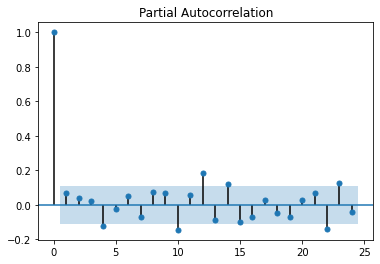

In [ ]:
plot_acf(result_arma.resid, lags=24)
plot_pacf(result_arma.resid, lags=24)
plt.show()

### Forecast using the estimated model with quadratic trend, a full set of seasonal dummies and AR(3)

First, forecast ```log(liquor sale)``` for 1994M1 - 1995M12 and compare it with the actual data

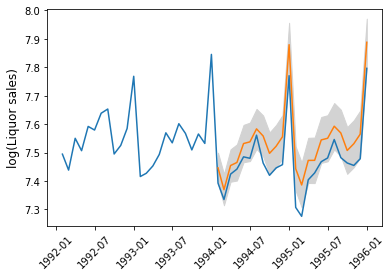

In [ ]:
forecast = result_arma.get_forecast(24, exog=df[X1][-24:])
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.plot(df['date'][-48:], df['logliquor'][-48:])
plt.plot(df['date'][-24:], mean_forecast.values)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('log(Liquor sales)', fontsize = 'large')

# Shade confidence interval
plt.fill_between(df['date'][-24:], confidence_interval['lower logliquor'], confidence_interval['upper logliquor'], color='lightgrey')
plt.show()

Forecast the **level** of liquor sale until 1998M12
- We need to construct the exogenous variables for the out-of-sample period

In [ ]:
exogdate = pd.date_range(start='1993-01-01', periods= 72, freq='M').to_frame(index=False, name='date')
month = pd.DatetimeIndex(exogdate['date']).month
exog_var = pd.get_dummies(month, prefix='m')
exog_var['time'] = exog_var.index - 24 + df.shape[0] + 1
exog_var['time2'] = exog_var['time']**2

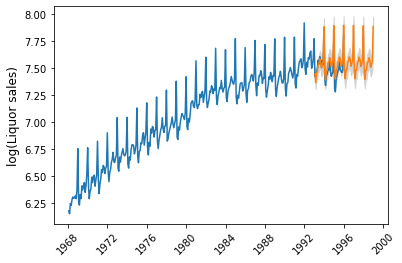

In [ ]:
forecast = result_arma.get_forecast(72, exog=exog_var[X1])
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.plot(df['date'], df['logliquor'])
plt.plot(exogdate, mean_forecast.values)
plt.fill_between(exogdate['date'], confidence_interval['lower logliquor'], confidence_interval['upper logliquor'], color='lightgrey')

ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('log(Liquor sales)', fontsize = 'large')

plt.show()

Plot the level of liquor sale and our forecast

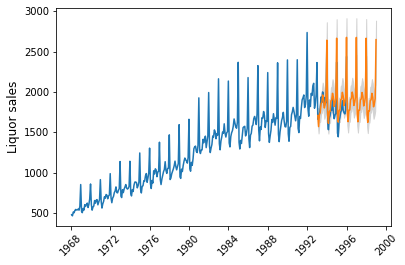

In [ ]:
liquor_mean = np.exp(mean_forecast)
liquor_lower = np.exp(confidence_interval['lower logliquor'])
liquor_upper = np.exp(confidence_interval['upper logliquor'])

plt.plot(df['date'], df['liquorsales'])
plt.plot(exogdate, liquor_mean)
plt.fill_between(exogdate['date'], liquor_lower, liquor_upper, color='lightgrey')

ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('Liquor sales', fontsize = 'large')

plt.show()

### Recursive estimation
First, construct lagged values of ```logliquor```

In [ ]:
df['L1_logliquor'] = df['logliquor'].shift(1)
df['L2_logliquor'] = df['logliquor'].shift(2)
df['L3_logliquor'] = df['logliquor'].shift(3)

In [ ]:
exog = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12', 'L1_logliquor', 'L2_logliquor', 'L3_logliquor']]
model = sm.RecursiveLS(df['logliquor'][3:], exog[3:])
result_rec = model.fit()
print(result_rec.summary())

                           Statespace Model Results                           
Dep. Variable:              logliquor   No. Observations:                  333
Model:                    RecursiveLS   Log Likelihood                 629.695
Date:                Wed, 10 Mar 2021   R-squared:                       0.995
Time:                        01:11:51   AIC                          -1225.391
Sample:                             0   BIC                          -1160.652
                                - 333   HQIC                         -1199.576
Covariance Type:            nonrobust   Scale                            0.001
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
time             0.0009      0.000      2.865      0.004       0.000       0.001
time2        -1.456e-06    4.8e-07     -3.037      0.002    -2.4e-06   -5.16e-07
m_1              0.5014      0.241      2.08

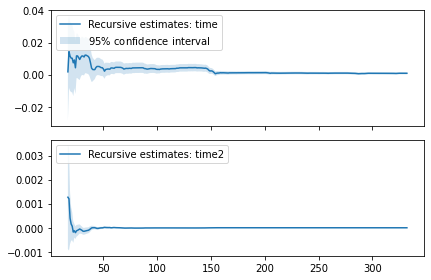

In [ ]:
# plot recursive parameter estimates for trend component
result_rec.plot_recursive_coefficient(range(0,2), figsize=(6,4));

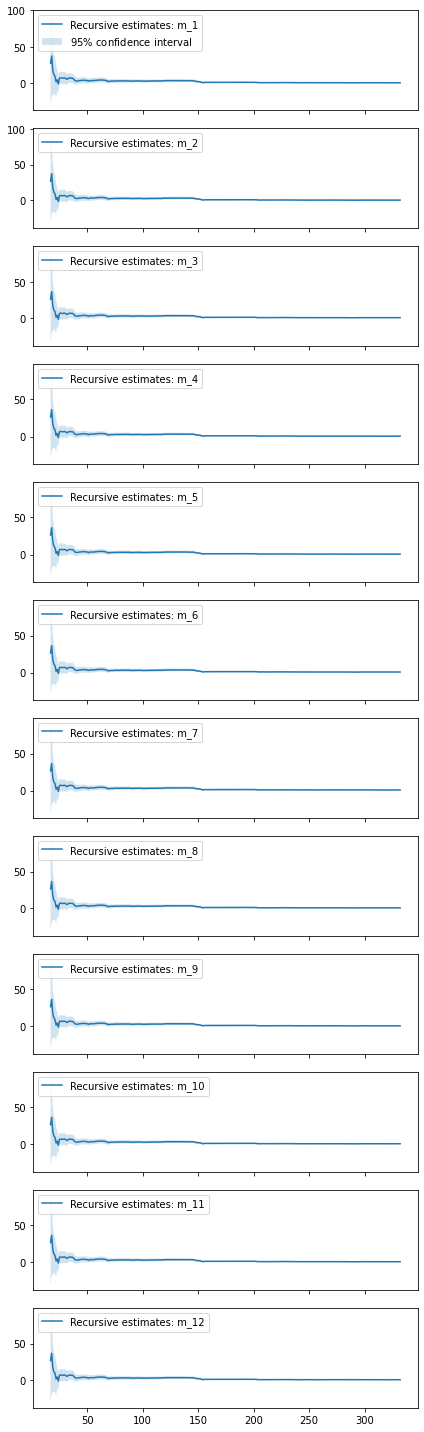

In [ ]:
# plot recursive parameter estimates for seasonal component
result_rec.plot_recursive_coefficient(range(2,14), figsize=(6,20));

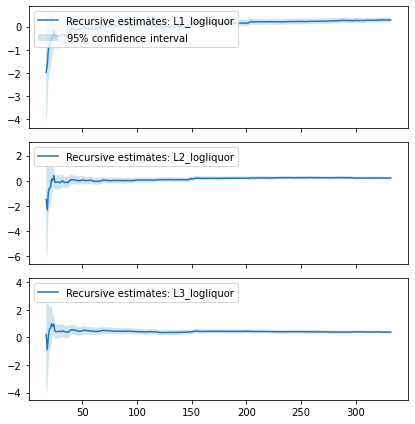

In [ ]:
# plot recursive parameter estimates for AR coefficients
result_rec.plot_recursive_coefficient(range(14,17), figsize=(6,6));

Cumsum plot

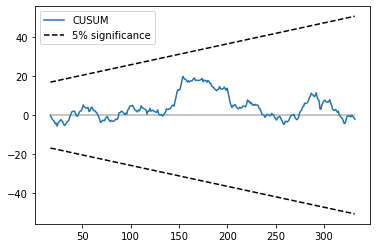

In [ ]:
fig = result_rec.plot_cusum()

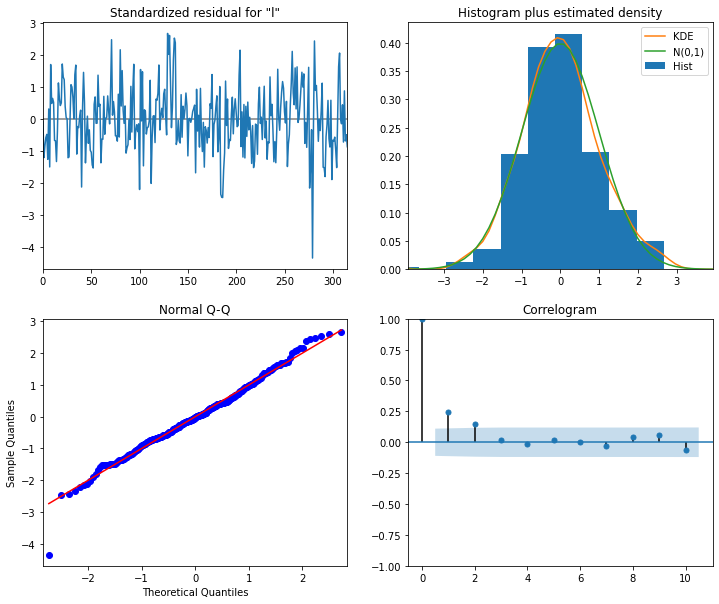

In [ ]:
fig = result_rec.plot_diagnostics(figsize=(12,10))